# Overfitting

**Prerequisites**

- Linear Algebra
- Linear Models


**Outcomes**

- Understand polynomial regression
- Understand and be able to diagnose overfitting
- Understand and be able to apply K-fold cross validation

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

## Warmup: Polynomial Regression

- Recall that a **linear model** is a model that is linear in *parameters*
- This may seem limiting, but can be quite expressive
- Two main dimensions of flexibility are:
    1. Link functions and residual families: GLM (last time)
    2. Feature engineering: transforming observed data $x \in \mathbb{X}$ (today+)
- Today we'll explore how the linear model can be *too flexible*
- We'll warm up with a contrived example of **polynomial regression**

### Notation

Define the convenience function *polynomial_features* that implements the polynomial feature mapping/transformation $\boldsymbol{\phi}(\cdot)$ for a $D$-degree polynomial

$$\begin{aligned}
    \phi_D(x) & \triangleq
    \begin{bmatrix}
        1       \\
        x \\
        x^2 \\ 
        \vdots \\
        x^{D-1} \\
        x^D
    \end{bmatrix}    
\end{aligned}$$

For a vector $\mathbf{x} \in \mathbb{R}^N$ as input argument, it constructs and returns the matrix

$$\begin{aligned}
    \Phi_D & \triangleq
    \begin{bmatrix}
        \phi_D^T(x_1) \\
        \phi_D^T(x_2) \\
        \vdots  \\
        \phi_D^T(x_N) \\ 
    \end{bmatrix} =    
    \begin{bmatrix}
        1 & x_1 & x_1^2 & \cdots & x_1^{D-1} & x_1^D  \\
        1 & x_2 & x_2^2 & \cdots & x_2^{D-1} & x_2^D  \\
        \vdots  \\
        1 & x_N & x_N^2 & \cdots & x_N^{D-1} & x_N^D
    \end{bmatrix} \in \mathbb{R}^{N \times (D+1)}   
\end{aligned}$$

### `sklearn.preprocessing.PolynomialFeatures`

The `sklearn.preprocessing` module contains many tools for preprocessing data

One of these tools is `PolynomialFeatures`

We'll use `PolynomialFeatures` to implement our $\Phi$ operator:

In [2]:
from sklearn import preprocessing

quad = preprocessing.PolynomialFeatures(degree=2)
cubic = preprocessing.PolynomialFeatures(degree=3)

x = np.arange(1, 8)

cubic.fit_transform(x[:, None])  # make x (N, 1) b/c sklearn expects matrix

array([[  1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.],
       [  1.,   3.,   9.,  27.],
       [  1.,   4.,  16.,  64.],
       [  1.,   5.,  25., 125.],
       [  1.,   6.,  36., 216.],
       [  1.,   7.,  49., 343.]])

### Experiment Setup

We will use 

To test out polynomial regression, we'll do an experiment:

1. Define a cubic polynomial with known coefficients $\theta_{\text{true}}$: $y = \theta_{\text{true}}^T \phi_3(x)$
2. Draw $x_i \stackrel{\text{iid}}{\sim} U[0, 3]$ for $i =1, \cdots, N$
3. Draw noise $\epsilon_i \stackrel{\text{iid}}{\sim} N(0, 0.05)$ for $i =1, \cdots, N$
4. Generate noisy data using from the polynomial: $y_i = \theta_{\text{true}}^T\phi_3(x_i) + \epsilon_i$

The observations $y_i$ will be noisy samples from our assumed data generating process

#### Define Polynomial

We will define a cubic polynomial, which we'll call the *true model*:

$$\begin{aligned}
    & f(x|\theta_{\mathrm{true}}) = \frac{A}{3} x^3 - \frac{A(a+b)}{2} x^2 + A a b x = \theta_{\mathrm{true}}^T \phi_3(x)
\end{aligned}$$

where the polynomial coefficients $\theta_{\mathrm{true}}$ are given as

$$\begin{aligned}
    \theta_{\mathrm{true}} & \triangleq
    \begin{bmatrix} 0 \\ A a b \\-\frac{A}{2}(a+b) \\ \frac{A}{3} \end{bmatrix}
\end{aligned}$$

and the polynomial feature map $\phi_3(\cdot)$ is given as

$$\begin{aligned}
    \phi_3(x) & \triangleq \begin{bmatrix} 1 \\ x \\ x^2 \\ x^3 \end{bmatrix}    
\end{aligned}$$

In [3]:
## True model (polynomial) specification

# The parameters that follow influence the shape of the polynomial (feel free to change)
a = 1.0    # First stationary point of polynomial
b = 1.5    # Second stationary point of polynomial
A = 2.0    # Scaling factor

# this is the reason for parametrization in the previous slide

# Polynomial coefficients (do not change)
theta_true = np.zeros(4)
theta_true[1] = A * a * b
theta_true[2] = - A * (a + b) / 2.0
theta_true[3] = A / 3.0

theta_true

array([ 0.        ,  3.        , -2.5       ,  0.66666667])

#### Draw $x_i$ and $\epsilon_i$

In [4]:
# there arent any true randomenss

np.random.seed(42)  # for reproducible results

# it generates the sequences everery time "seed"
# then we pick 100 samples

N = 100
xmin = 0
xmax = 3
x = xmin + (xmax - xmin) * np.random.rand(N)

sigma = 0.05
epsilon = np.random.randn(N) * np.sqrt(sigma)

# samples times errors

#### Generate $y_i$ using $\theta_{\text{true}}$

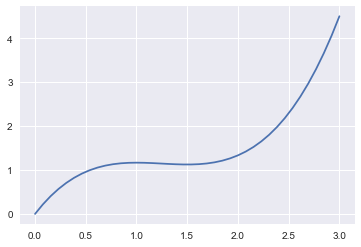

In [5]:
## Construct the target values
Phi = cubic.fit_transform(x[:, None])
y = Phi @ theta_true + epsilon

# also construct data for plotting later
x_plot = np.linspace(xmin, xmax, 40)
y_true_plot = cubic.fit_transform(x_plot[:, None]) @ theta_true

plt.plot(x_plot, y_true_plot);

### Data Partitioning

The available data will be partitioned into a *training* set and *test* set (i.e. samples not used for training/fitting)

In particular, the test set will be used to obtain an honest estimate of how good the model performs on previously unseen samples (i.e. samples other than ones used for training)

We'll use `sklearn.model_selection.train_test_split` for this

In [6]:
from sklearn import model_selection

In [7]:
## Partition data into training and test set
# Number of training samples (feel free to change)
N_train = 10

# 10/100 from our sample = trraiin

x_train, x_test, y_train, y_test = model_selection.train_test_split(  
    x, y, train_size=N_train
) 

# split the data with command

### Model Training/Fitting

Let's now run a degree-3 polynomial regression to see how well we can fit the data

In [8]:
from sklearn import linear_model, metrics

# construct feature matrix --> the cubic polynomial transformation gives us the X_train
model = linear_model.LinearRegression()
X_train = cubic.fit_transform(x_train[:, None])

# choose and fit model --> at this stage the model would be fiitt
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# compute predictions on training data --> prediction on the predictioon subset
y_hat_train = model.predict(X_train)

# evaluate mse
mse_train = metrics.mean_squared_error(y_train, y_hat_train)

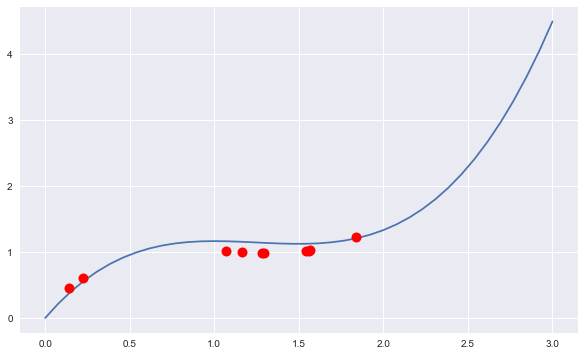

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_plot, y_true_plot)
ax.plot(x_train, y_hat_train, "r.", ms=20);

# we see that blue line is the true model
# red dots are the prediction

Overall the fit looks pretty good!

Let's check the coefficients and the mse:

In [10]:
theta_true

array([ 0.        ,  3.        , -2.5       ,  0.66666667])

In [11]:
model.coef_

array([ 0.        ,  2.69409432, -2.58556271,  0.78576315])

In [12]:
mse_train

0.013100638551202004

#### Test set prediction

Now let's evaluate our fit model on the test data

In [13]:
X_test = cubic.transform(x_test[:, None])
y_hat_test = model.predict(X_test)
mse_test = metrics.mean_squared_error(y_test, y_hat_test)

In [14]:
print('The optimal coefficients are:\n')
print(model.coef_)

print('\n')

print('The (minimum) MSE of the fitted model as computed on the training set is\nMSE_train={:.3f}\n'.format(mse_train))
print('The MSE of the fitted model as computed on the test set is\nMSE_test={:.3f}\n'.format(mse_test))
print('The noise variance of the true model is\nsigmaSquared_e={:.3f}\n'.format(sigma))

The optimal coefficients are:

[ 0.          2.69409432 -2.58556271  0.78576315]


The (minimum) MSE of the fitted model as computed on the training set is
MSE_train=0.013

The MSE of the fitted model as computed on the test set is
MSE_test=0.307

The noise variance of the true model is
sigmaSquared_e=0.050



### Visualizing Results

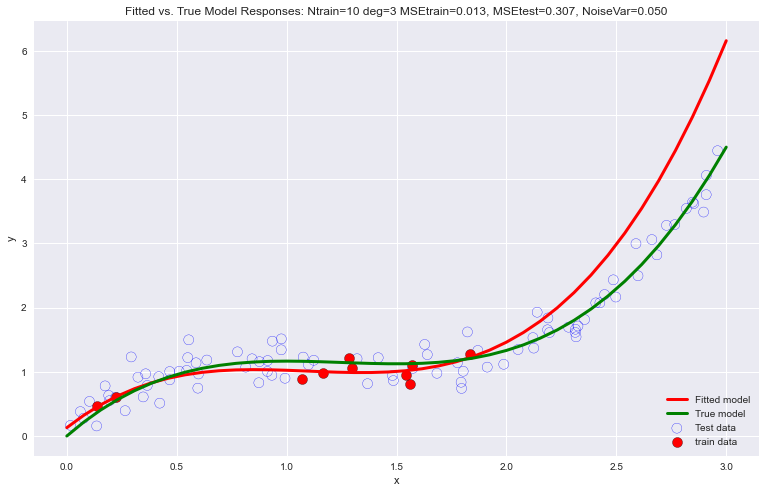

In [15]:
# Resize figure to make it bigger
fig, ax = plt.subplots(figsize=(13, 8))

X_plot = cubic.transform(x_plot[:, None])
y_hat_plot_fitted = model.predict(X_plot)
polydegree = 3

ax.plot(x_plot, y_hat_plot_fitted, 'r', lw=3, label="Fitted model")
ax.plot(x_plot, y_true_plot, 'g', lw=3, label="True model")
ax.scatter(x_test, y_test, s=100, facecolors='none', edgecolors='b', label="Test data")
ax.scatter(x_train, y_train, s=100, facecolors='r', edgecolors='k', label="train data")

# Annotate graph
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')
ax.set_title((
    "Fitted vs. True Model Responses: "
    f"Ntrain={N_train:d} deg={polydegree:d} MSEtrain={mse_train:.3f}, "
    f"MSEtest={mse_test:.3f}, NoiseVar={sigma:.3f}"
));

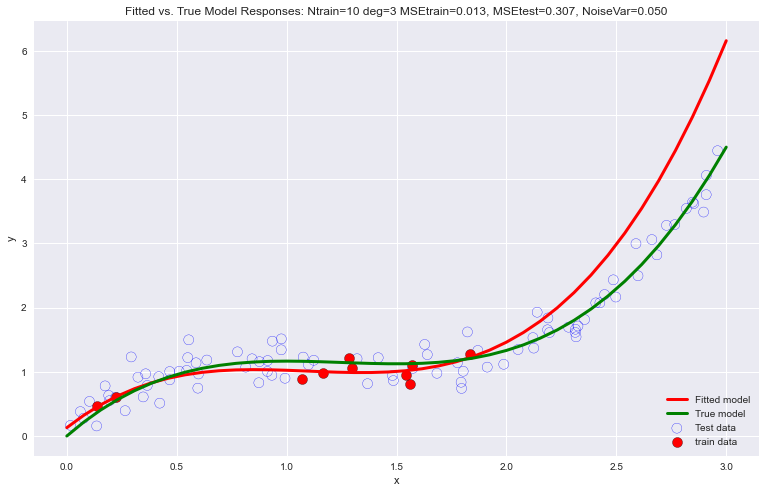

In [16]:
fig

Notice that the largest training sample $x$ is just less than 2.0

The model fits best in the region closest to the training data

As we evaluate the model at x > 2.5 the fit deteriorates and the residuals increase

This is known as poor *generalization*

Generalization refers to the ability for a model to produce accurate predictions on unseen data. This is the **main goal** of supervised learning

### Interactive Example

Above we saw how we could assume a data generating process where $y$ was related to $x$ by a cubic polynomial

Unsurprisingly, we found that if we fit noisy observations $(y_i, x_i)$ using a cubic polynomial we had a good fit in the region of the training data

What if we were to use a degree 4 or degree 5 polynomial? Would the fit improve? How about generalization?

We will use jupyter widgets to construct an interactive

In [24]:
from sklearn import pipeline
from ipywidgets import widgets

# pipeline --> meaningful for the transformations
# suppose we want to go through somoe processing steps--> preprocessing, i.e., standard scalar

def polyreg_demo(degree=3, n_train=10):
    # define model
    model = pipeline.make_pipeline(
        preprocessing.PolynomialFeatures(degree=degree),
        linear_model.LinearRegression()
    )
    
    X = x[:, None]  # convert to 2d
    test_size = X.shape[0] - n_train
    split = model_selection.train_test_split(X, y, train_size=n_train, test_size=test_size, random_state=12)
    X_train, X_test, y_train, y_test = split
   
    # fit model
    model.fit(X_train, y_train)
    yhat = model.predict(x_plot[:, None])
    
    # compute metrics
    mse_train = metrics.mean_squared_error(y_train, model.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, model.predict(X_test))

    # make the plot
    fig, ax = plt.subplots(figsize=(15, 11))
    ax.plot(x_plot, yhat, "k-", lw=3, label="Fitted Model")
    ax.scatter(X_test.flatten(), y_test, color="b", s=60, alpha=0.5, label="Test Data")
    ax.scatter(X_train.flatten(), y_train, color="r", s=80, alpha=0.7, label="Training Data") 
    ax.set_ylim((-20, 20))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='upper left')
    ax.set_title((
        "Fitted vs. True Model Responses: "
        f"Ntrain={n_train:d} deg={degree:d} MSEtrain={mse_train:.3f}, "
        f"MSEtest={mse_test:.3f}, NoiseVar={sigma:.3f}"
    ))
    
    return fig


widgets.interactive(polyreg_demo, degree=(1, 10, 1), n_train=(5, 95, 1))

interactive(children=(IntSlider(value=3, description='degree', max=10, min=1), IntSlider(value=10, description…

Things to try:

- Try leaving degree at 3, but moving n_train to 2 or 1. What happens?
- Now set n_train to 10 and try moving degree from 3 towards 10. What happens to MSEtrain as degree increases? what about MSEtest?

## Overfitting

- As shown above, when the number of training samples is too low relative to the model complexity the model will often exhibit very good training properties (i.e. a low `MSEtrain`), but very poor generalization (i.e. a high `MSEtest`)
- This is called **overfitting** and is one of the most common problems machine learning practitioners have to grapple with
- An overfit model is dangerous because it can make the modeler feel confident due to good training metrics, but then give very wrong predictions in practice

### Diagnosing Overfitting

- It is important to check for and diagnose overfitting
- Common strategy:
    1. Split dataset into training and testing subsets
    2. Train data only on training subset
    3. Evaluate metrics on both training and testing subsets
    4. Compare MSE train to MSE test
- This is what we did above

### Strategies for overcoming Overfitting

- Once overfitting has been diagnosed, there are three standard counterattacks:

1. Use more training data
2. Use a less complex model (perhaps use fewer features)
3. Use a regularization approach (stay tuned!)

- Often (1) is not possible or feasible
- Sometimes relationships are highly non-linear and complex, ruling out (2)
- (3) is the most commonly used approach for complex models and big data (e.g. modern deep networks)
- Implementing (2) or (3) surfaces need to be able to select from a set of candidate models...

### Model Selection

-   Select from a set of models with varying flexibility
-   **Goal**: Choose a model that has the best generalization
    properties

-   Example: polynomial regression
    -   Varying number of features, controlled by degree $D$ of
        polynomial
    -   The number $D$ indexes a family of regression models and
        controls flexibility
    -   Optimal $D$ cannot be determined based solely on training set
        (beware of overfitting!)
    -   Parameters like $D$ are called **hyper parameters**

#### Model Selection continued ...

**Main point**

-   Model selection cannot be solely based on the training set
-   Training MSE informs us about model fit, but not necessarily about
    the model's generalization performance (not trustworthy)
-   A (more) honest loss estimate needs to be employed
    -   We used a hold-out set for this purpose (more trustworthy)

**Validation Procedure**

-   An approach to model selection: out of a pool of candidate models,
    guess which one may exhibit the best generalization (let's decide to
    call it the **champion model**)

### Validation Procedures

-   There are many, we'll only cover a few
- The pattern described above is called the **Hold out method**
- We'll repeat here for practice:
    1.   Partition available data into training (typically, larger set)
         and (typically, smaller set) hold-out set, called the
         **validation set**.
    2.   Fit models on training set
    3.   Select model with smallest average loss on hold-out set
-   Considerations
    -   Large training set $\Longrightarrow$ better fitting models
    -   The larger the validation set, the better quality of the
        generalization estimate (e.g. $\text{MSE}_{\text{val}}$)
    -   Assumes there are plenty of data for both sets

#### Aside: train, test, validate

- The process above labeled a hold out set the validation set
- This is distinct from the testing dataset we used in our polynomial regression example
- In a full setup, you may split the dataset into three partitions:
    1. Training: largest, used for training model
    2. Validation: medium size, used for tuning hyperparameters of each model
    3. Testing: smallest, used to compare generalization properties of candidate models

### K-fold Cross Validation

-   Partition available data into $K$ equally-sized subsets
    (**folds**)
-   For $k=1$ to $K$
    -   Pick a fold to play the role of the validation set
    -   Use the remaining $K-1$ folds for training the models
    -   Compute the average loss on the validation set/fold
-   Use the sample average of the
    $\left\{\text{MSE}_{\text{val}}^k \right\}_{k=1}^K$ to guess the
    best generalizing model (champion)

#### K-fold... vizualized

![Simple Linear Regression](https://css-materials.s3.amazonaws.com/ML/overfitting/kfold_crossval.png)

#### K-fold CV

-   Considerations for K-fold CV
    -   For fixed number of available data $N$
        -   large $K$ $\Longrightarrow$ large training sets and small
            validation sets $\Longrightarrow$ worse quality of
            generalization performance estimate
    -   Used when data are deemed "not enough" to employ hold-out method
    -   Often, people use K=10 (although completely arbitrary)
-   Leave ont out cross validation (LOOCV)
    -   K-fold CV to the extreme: $K = N$
    -   Considerations
        -   Used when available data are "too few"
        -   Training sets almost identical from fold to fold
            $\Longrightarrow$ trained models typically differ by very
            little from fold to fold

#### Example: Apply to Polynomial Regression

- Let's work through an example of K-fold cross validation using our polynomial regression laboratory

In [18]:
# define a helper function
# pipeline is like a model--> all the features are passed tto x before wee run our linear rergression

def polyreg_model(degree):
    return pipeline.make_pipeline(
        preprocessing.PolynomialFeatures(degree=degree),
        linear_model.LinearRegression(fit_intercept=False)
    )

# construct the model
# then get the prediction on the test data only
# then we compute the mse on the whole data 

def fit_polyreg_return_mse(train_x, train_y, test_x, test_y, degree):
    model = polyreg_model(degree)
    model.fit(train_x, train_y)
    test_yhat = model.predict(test_x)
    return metrics.mean_squared_error(test_y, test_yhat)

# number of folds = numnber of splits

def do_k_fold_validation_polyreg(k, x, y, degrees):
    model_scores = {d: 0.0 for d in degrees}
    
    kf = model_selection.KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(x):  # repeated k times
        # split data
        x_train = x[train_index, None]
        y_train = y[train_index]
        
        x_test = x[test_index, None]
        y_test = y[test_index]
        
        for d in degrees:
            score = fit_polyreg_return_mse(x_train, y_train, x_test, y_test, degree=d)
            model_scores[d] += score
        # we keep our running total as a running sum

    # compute average of model scores
    return {d: mse / k for d, mse in model_scores.items()}

In [19]:
# lets do 10 folds

do_k_fold_validation_polyreg(10, x, y, range(1, 31))

{1: 0.27185204713561617,
 2: 0.15234330533859702,
 3: 0.04209359843538811,
 4: 0.042038300886175405,
 5: 0.0425737687823326,
 6: 0.042961726146441295,
 7: 0.04437348751658121,
 8: 0.0466002957847713,
 9: 0.049476927042232964,
 10: 0.0485543527110323,
 11: 0.045647387469462196,
 12: 0.04581812491950105,
 13: 0.04806767640304716,
 14: 0.0477687910383283,
 15: 0.04891476860553724,
 16: 0.057715992984936806,
 17: 0.1996712712407379,
 18: 0.29291998199195596,
 19: 0.47293538447108796,
 20: 0.6842593354224056,
 21: 0.8158757561622043,
 22: 0.8231306859931278,
 23: 0.7100608548202574,
 24: 0.5135901022466176,
 25: 0.35936096298329334,
 26: 0.28338669253170845,
 27: 0.3301771871379541,
 28: 0.34470504200412305,
 29: 0.5814001639726565,
 30: 0.7202224141972401}

#### Using Sklearn

We can actually simplify our code quite a bit by letting Sklearn handle the details for us

In [20]:
def k_fold_crossval_via_sklearn(k, x, y, degrees):
    scores = {}
    for d in degrees:
        model = polyreg_model(d)
        mses = model_selection.cross_val_score(
            model, 
            x[:, None], 
            y,  
            scoring='neg_mean_squared_error', 
            cv=k
        )
        scores[d] = -mses.mean()
    return scores

In [25]:
k_fold_crossval_via_sklearn(10, x, y, range(1, 31))

# result is that we get here to a similar pattern

{1: 0.28097089120052854,
 2: 0.14963837080139247,
 3: 0.04294114765271715,
 4: 0.04329820333912244,
 5: 0.04429676401137081,
 6: 0.045273272811973395,
 7: 0.04630245146446353,
 8: 0.048808923623809876,
 9: 0.05196057519542323,
 10: 0.050518406099538324,
 11: 0.04669056103186242,
 12: 0.04754825657108916,
 13: 0.04972287512337818,
 14: 0.05431100971955899,
 15: 0.06344477271429379,
 16: 0.0750118308062875,
 17: 0.1043664765016356,
 18: 0.20907229997219554,
 19: 0.44083414163000834,
 20: 0.7537285057273888,
 21: 1.0021771267285289,
 22: 1.1064195575976798,
 23: 1.064810721917763,
 24: 0.9170308577236093,
 25: 0.7771281139006911,
 26: 0.7094441301427741,
 27: 0.6492273937891316,
 28: 0.7016308759024437,
 29: 0.5892859198159585,
 30: 0.9096255779044334}

#### LOOCV with Linear Regression

An amazing thing...

-   The LOOCV estimate for linear regression has a closed form based on the diagonal elements of the hat matrix $\mathbf{H}$.
$$\begin{aligned}
    \text{MSE}_{\text{loocv}} &= \frac{1}{N} \sum_{n=1}^{N} \frac{\hat{e}_n^2}{(1 - h_{n,n})^2} = \frac{1}{N}\hat{\mathbf{e}}^{*T} \left(\mathbf{I}_N - \mathbf{H}_{\text{diag}} \right)^{-2} \hat{\mathbf{e}}^* \\
    & \text{ } \\
    \mathbf{H} &\triangleq \mathbf{X} \mathbf{X}^{\dagger} \\
    \mathbf{H}_{\text{diag}} &\triangleq \text{diagonal elements of } \mathbf{H} = \begin{bmatrix}
        h_{1,1} & 0 & \cdots \\
        0 & h_{2,2} & \cdots \\
        \vdots & \vdots & \ddots
    \end{bmatrix}
\end{aligned}$$
-   In the literature it is called the **P**redicted **R**esidual **E**rror **S**um of**S**quares (PRESS) statistic
-   In essence it is a weighted form of the training MSE
- NOTE: can be computed by fitting *1* model, not *N*

#### Example

Let's test out this finding with our polynomial regression

In [22]:
quad_model = polyreg_model(degree=2)
quad_model.fit(x[:, None], y)
eps_star = quad_model.predict(x[:, None]) - y

X = quad.fit_transform(x[:, None])
H = X @ np.linalg.pinv(X)
hh = np.diagonal(H)
mse_loocv = np.mean((eps_star /(1-hh))**2)
mse_loocv

0.15298732393772027

In [23]:
do_k_fold_validation_polyreg(len(x), x, y, [2])

{2: 0.15298732393772024}

#### Comments about Model Selection

-   Hold-out method more reliable than K-fold CV or LOOCV
    -   It will provide most honest estimate of generalization
        performance
    -   However, hold-out data is not used for training\...
    -   It is most commonly used when there is ample data
-   In general, the best validation procedure depends on
    1.  The context of the ML task
    2.  The size of available data set
    3.  Efficiency/feasibility concerns
    4.  The choice of hyper-parameters (such as the number of folds $K$
        in K-fold CV)
-   This is a **difficult problem** that is being actively researched